In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import obonet
import BOCC
import pandas as pd
import numpy as np
import math
from webweb import Web
import os
import seaborn as sns
from BOCC import BOCC, load_clusters
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import typing
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from upsetplot import from_memberships
from upsetplot import plot

std_fontsize = 12

/Users/michael/miniconda3/envs/bocc/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
# Define jane's information
jane_hpos = ['HP:0002066','HP:0020221','HP:0032792','HP:0001733','HP:0001824']
jane_hpo_common_names = ['Gait ataxia','Clonic seizures','Tonic seizures','Pancreatitis','Weight loss']
jane_genes = ['SSPO','NBEA']

In [3]:
def clear_ax(ax, top=False, bottom=False, left=False, right=False):
    ax.spines['top'].set_visible(top)
    ax.spines['bottom'].set_visible(bottom)
    ax.spines['left'].set_visible(left)
    ax.spines['right'].set_visible(right)
    # ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(True)
    ax.yaxis.set_tick_params(width=0.0, labelsize=8)
    ax.xaxis.set_tick_params(width=0.0, labelsize=8)


In [4]:
# load the graphs
G = nx.read_edgelist('../Edgelists/String_HPO_2021.phenotypic_branch.edgelist.txt')
G19 = nx.read_edgelist('../Edgelists/String_HPO_2019.phenotypic_branch.edgelist.txt')
G20 = nx.read_edgelist('../Edgelists/String_HPO_2020.phenotypic_branch.edgelist.txt')
G21 = nx.read_edgelist('../Edgelists/String_HPO_2021.phenotypic_branch.edgelist.txt')
G22 = nx.read_edgelist('../Edgelists/String_HPO_2022.phenotypic_branch.edgelist.txt')

hpos = [x for x in G.nodes if 'HP:' in x]
genes = [x for x in G.nodes if 'HP:' not in x]

In [5]:
# what is the median number of PPIs
# ppi_counts = []
# for g in genes:
#     ppi_counts.append(len([x for x in G.neighbors(g) if x in genes]))

# print('Median PPI',np.median(ppi_counts))

In [6]:
# load the original clusters
# remove trival communities
def remove_trivial_coms(coms):
    keepers = []
    for c in coms:
        if len(c.members) > 2 and len(c.get_genes()) > 0 and len(c.get_genes()) != len(c.members):
            keepers.append(c)
    return keepers

g_coms = load_clusters('../Clusters/2021/greedy.2021.coms.txt')
w_coms = load_clusters('../Clusters/2021/walktrap.2021.coms.txt')
i_coms = load_clusters('../Clusters/2021/infomap.2021.coms.txt')
c_coms = load_clusters('../Clusters/2021/cesna.2021.coms.txt')

In [7]:
# do the same things as above but with the paris 2021 crosses
g_subcoms = load_clusters('../SubComs/2021/paris.greedy.2021.coms.txt')
w_subcoms = load_clusters('../SubComs/2021/paris.walktrap.2021.coms.txt')
i_subcoms = load_clusters('../SubComs/2021/paris.infomap.2021.coms.txt')
c_subcoms = load_clusters('../SubComs/2021/paris.cesna.2021.coms.txt')

print('# sub clusters',sum([len(g_subcoms),len(w_subcoms),len(i_subcoms),len(c_subcoms)]))
g_subcoms = remove_trivial_coms(g_subcoms)
w_subcoms = remove_trivial_coms(w_subcoms)
i_subcoms = remove_trivial_coms(i_subcoms)
c_subcoms = remove_trivial_coms(c_subcoms)
print('# non-trivial sub clusters',sum([len(g_subcoms),len(w_subcoms),len(i_subcoms),len(c_subcoms)]))

# sub clusters 32767
# non-trivial sub clusters 3696


In [23]:
# do the same things as above but with the paris 2020 crosses
g_subcoms_20 = load_clusters('../SubComs/2020/paris.greedy.2020.coms.txt')
w_subcoms_20 = load_clusters('../SubComs/2020/paris.walktrap.2020.coms.txt')
i_subcoms_20 = load_clusters('../SubComs/2020/paris.infomap.2020.coms.txt')
c_subcoms_20 = load_clusters('../SubComs/2020/paris.cesna.2020.coms.txt')

print('# 2020 sub clusters',sum([len(g_subcoms),len(w_subcoms),len(i_subcoms),len(c_subcoms)]))
g_subcoms_20 = remove_trivial_coms(g_subcoms_20)
w_subcoms_20 = remove_trivial_coms(w_subcoms_20)
i_subcoms_20 = remove_trivial_coms(i_subcoms_20)
c_subcoms_20 = remove_trivial_coms(c_subcoms_20)
print('# 2020 non-trivial sub clusters',sum([len(g_subcoms),len(w_subcoms),len(i_subcoms),len(c_subcoms)]))

# 2020 sub clusters 3696
# 2020 non-trivial sub clusters 3696


In [8]:
"""
can you send me a file that is “cluser_id cluster_score gene_name num_g2p_connections num_pottential_g2p_connections”
one file per algorithm?
the last two columns are intra cluster
"""
# predicted_df = pd.read_csv('../XGBoost2021ClusterRankings.csv')
cluster_scores = {}
first= True
for line in open('../XGBoost2021ClusterRankings.csv','r'):
    if first:
        first = False
        continue
#     print(line)
    row = line.strip().split(',')
    cluster_scores[row[0]] = 1 - float(row[1])
    
def export_gene_in_cluster_stats(coms,g,scores,prefix,outfile):
    data_to_save = {'com_id':[],'cluster_score':[],'genes':[],'num_g2p_connections':[],'num_potential_g2p_connections':[]}
    for com in coms:
        com_name = prefix + com.name
        if com_name not in scores:
            continue
        genes = [n for n in com.members if 'HP:' not in n]
        hpos = [n for n in com.members if 'HP:' in n]
        g2 = g.subgraph(com.members)
        # count the number of g2p connects in each cluster
        for gene in genes:
            #get the number of HPO neighbors of gene
            num_hpo_neighbors = len([n for n in g2.neighbors(gene) if 'HP:' in n])
            num_possible_new_g2p = len(hpos) - num_hpo_neighbors
    #         print(num_g2p, num_possible_new_g2p)
            data_to_save['com_id'].append(com_name)
            data_to_save['cluster_score'].append(scores[com_name])
            data_to_save['genes'].append(gene)
            data_to_save['num_g2p_connections'].append(num_hpo_neighbors)
            data_to_save['num_potential_g2p_connections'].append(num_possible_new_g2p)
    tmp_df = pd.DataFrame(data_to_save)
    tmp_df.to_csv(outfile,sep='\t',index=False)

export_gene_in_cluster_stats(w_subcoms,G21,cluster_scores,'paris.walktrap.2021:','paris.walktrap.2021.g2p_counts.tsv')
export_gene_in_cluster_stats(g_subcoms,G21,cluster_scores,'paris.greedy.2021:','paris.greedy.2021.g2p_counts.tsv')
export_gene_in_cluster_stats(i_subcoms,G21,cluster_scores,'paris.infomap.2021:','paris.infomap.2021.g2p_counts.tsv')
export_gene_in_cluster_stats(c_subcoms,G21,cluster_scores,'paris.cesna.2021:','paris.cesna.2021.g2p_counts.tsv')

In [9]:
print('# all clusters',sum([len(g_coms),len(w_coms),len(i_coms),len(c_coms),]))

g_coms = remove_trivial_coms(g_coms)
w_coms = remove_trivial_coms(w_coms)
i_coms = remove_trivial_coms(i_coms)
c_coms = remove_trivial_coms(c_coms)

print('# non-trivial clusters',sum([len(g_coms),len(w_coms),len(i_coms),len(c_coms)]))

# all clusters 27809
# non-trivial clusters 1970


## Yearly Stats

In [10]:
# count node and edge type stats
def count_size_stats(_G):
    # count genes
    num_genes = sum(['HP:' not in n for n in _G.nodes])
    # count HPOs
    num_hpos = sum(['HP:' in n for n in _G.nodes])
    # 0 = p2p, 1 = p2g, 2 = p2p
    hpo_counts = [ sum(['HP:' in x for x in e]) for e in _G.edges]
    # count g2p
    num_g2p = hpo_counts.count(1)
    # count g2g
    num_p2p = hpo_counts.count(2)
    # count p2p
    num_g2g = hpo_counts.count(0)
    return [num_genes, num_hpos, num_p2p, num_g2p, num_g2g]

plt_data = {'year':[],'type':[],'count':[]}
# for y,_g in zip(list(range(2015,2023)),[G15,G16,G17,G18,G19,G20,G21]):
for y,_g in zip(list(range(2019,2023)),[G19,G20,G21,G22]):    
    stats = count_size_stats(_g)
    for t,x in zip(['STRING nodes', 'HPO nodes', 'HPO edges', 'gene-to-phenotype edges', 'STRING edges'],stats):
        plt_data['year'].append(y)
        plt_data['type'].append(t)
        plt_data['count'].append(x)
plt_df = pd.DataFrame(plt_data)

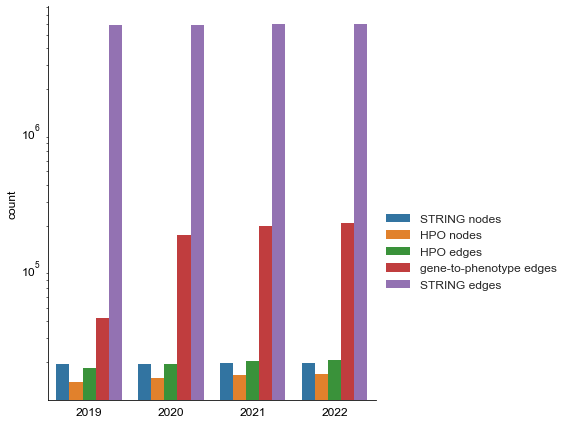

In [11]:
# plt.figure(figsize = (6,6))
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

# sns.catplot(
#     data=plt_df, kind="bar",
#     x="year", y="count", hue="type",
#     ci="sd",ax=ax)

sns.barplot(data=plt_df,x='year',y='count',hue='type',ax=ax)
sns.set_style("whitegrid", {'axes.grid' : False})

clear_ax(ax,bottom=True, left=True)

plt.legend(frameon=False,title=None,bbox_to_anchor=(1, 0.5),fontsize=std_fontsize)
plt.yscale('log')
ax.set_xlabel('')
plt.xticks(fontsize=std_fontsize)
plt.yticks(fontsize=std_fontsize)
plt.ylabel('count',fontsize=std_fontsize)
plt.tight_layout()
plt.savefig('../PublicationFigures/yearly_stats.png',dpi=300)
plt.show()

In [12]:
yearly_changes = {'year':[],'type':[],'change':[]}
# calculate the difference from previous years
for year in range(2019,2023):
    next_year = year
    sub = plt_df[plt_df['year'] == 2019]
    next_sub = plt_df[plt_df['year'] == next_year]
    for t in sub['type'].unique():
        sub_type_value = int(sub[sub['type'] == t]['count'])
        next_sub_type_value = int(next_sub[next_sub['type'] == t]['count'])
        difference = next_sub_type_value - sub_type_value
        percent_change = difference/sub_type_value
#         print(year,t,percent_change)
#         print(year,t,difference)
#         print()
        yearly_changes['year'].append(year)
        yearly_changes['type'].append(t)
        yearly_changes['change'].append(percent_change)
yearly_change_df = pd.DataFrame(yearly_changes)

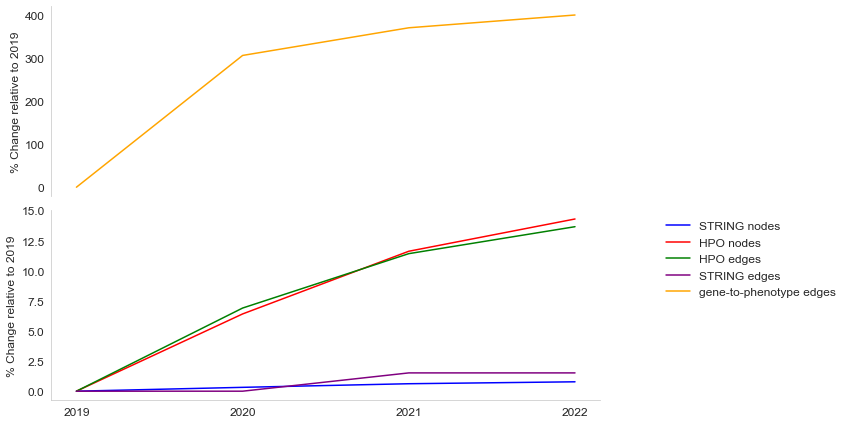

In [13]:
# print(yearly_change_df)
fig, ax = plt.subplots(2)
fig.set_size_inches(12, 6)
yearly_change_df['percent_change'] = [ round(x*100,2) for x in yearly_change_df['change']]
handles = []
colors = ['blue','red','green','orange','purple']
for i,t in enumerate(yearly_change_df['type'].unique()):
    if t == 'gene-to-phenotype edges':
        continue
    sub = yearly_change_df[yearly_change_df['type'] == t]
    ax[1].plot(sub['year'],sub['percent_change'], color=colors[i])
    legend_piece = Line2D([0], [0], color=colors[i], label=t)
    handles.append(legend_piece)

sub = yearly_change_df[yearly_change_df['type'] == 'gene-to-phenotype edges']
ax[0].plot(sub['year'],sub['percent_change'],label='gene-to-phenotype edges',color=colors[-2])
legend_piece = Line2D([0], [0],color=colors[-2], label='gene-to-phenotype edges')
handles.append(legend_piece)
    
ax[0].set_xticks([])
ax[1].set_xticks([2019,2020,2021,2022])


clear_ax(ax[0],bottom=False, left=True)
clear_ax(ax[1],bottom=True, left=True)

ax[1].tick_params(axis='both', which='major', labelsize=std_fontsize)
ax[1].tick_params(axis='both', which='minor', labelsize=std_fontsize)

ax[0].tick_params(axis='both', which='major', labelsize=std_fontsize)
ax[0].tick_params(axis='both', which='minor', labelsize=std_fontsize)


ax[0].set_ylabel('% Change relative to 2019', fontsize=std_fontsize)
ax[1].set_ylabel('% Change relative to 2019', fontsize=std_fontsize)

ax[1].legend(handles=handles, bbox_to_anchor=(1.1, 1), frameon=False, fontsize=std_fontsize)
plt.tight_layout()

plt.savefig('../PublicationFigures/yearly_change_stats.png',dpi=300)

plt.show()


## Cluster & Sub Cluster Size

0 greedy
1 walktrap
2 infomap
3 cesna
0 greedy-paris
1 walktrap-paris
2 infomap-paris
3 cesna-paris


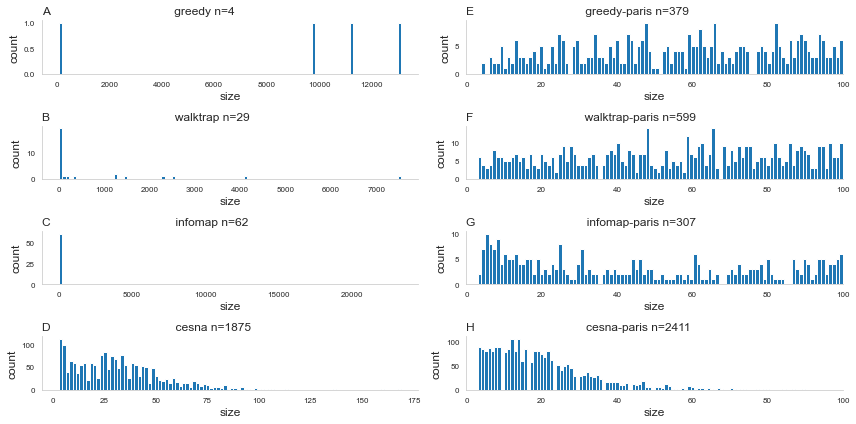

In [14]:
# plot size distribution of original coms
fig, axes = plt.subplots(4,2)
fig.set_size_inches(12, 6)

spaces = '                                     '
letters = ['A','B','C','D']
for i,n in enumerate(zip([g_coms,w_coms,i_coms,c_coms],['greedy','walktrap','infomap','cesna'])):
    print(i,n[1])
    xs = [ len(c.members) for c in n[0]]
    ys = [ len(c.get_genes()) / (len(c.members) - len(c.get_genes())) if len(c.get_genes()) != len(c.members) else 1 for c in n[0]]
    axes[i,0].set_title('{letter}{spaces}{algo} n={n}'.format(algo=n[1],n=str(len(n[0])),letter=letters[i],spaces=spaces),loc='left')
    axes[i,0].hist(xs,bins=100)
    axes[i,0].set_xlabel('size',fontsize=std_fontsize)
    axes[i,0].set_ylabel('count',fontsize=std_fontsize)
    clear_ax(axes[i,0],bottom=True, left=True)

spaces = '                                 '
letters = ['E','F','G','H']
for i,n in enumerate(zip([g_subcoms,w_subcoms,i_subcoms,c_subcoms],['greedy-paris','walktrap-paris','infomap-paris','cesna-paris'])):
    print(i,n[1])
    xs = [ len(c.members) for c in n[0]]
    ys = [ len(c.get_genes()) / (len(c.members) - len(c.get_genes())) if len(c.get_genes()) != len(c.members) else 1 for c in n[0]]
    axes[i,1].set_title('{letter}{spaces}{algo} n={n}'.format(algo=n[1],n=str(len(n[0])),letter=letters[i],spaces=spaces),loc='left',fontsize=std_fontsize)
    axes[i,1].hist(xs,bins=100)
    axes[i,1].set_xlabel('size',fontsize=std_fontsize)
    axes[i,1].set_xlim((0,100))
    axes[i,1].set_ylabel('count',fontsize=std_fontsize)
    clear_ax(axes[i,1],bottom=True, left=True)
plt.tight_layout()
plt.savefig('../PublicationFigures/clusters_2021_non_trivial_size_dist.png',dpi=300)
plt.show()


## Snowball simulation results

In [15]:
# load rediscovery stats
g_snow = pd.read_csv('../SnowballResults/snowball.paris.greedy.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
w_snow = pd.read_csv('../SnowballResults/snowball.paris.walktrap.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
i_snow = pd.read_csv('../SnowballResults/snowball.paris.infomap.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
c_snow = pd.read_csv('../SnowballResults/snowball.paris.cesna.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
print(g_snow.shape)
print(w_snow.shape)
print(i_snow.shape)
print(c_snow.shape)

(182900, 5)
(80400, 5)
(385500, 5)
(2847100, 5)


In [16]:
def control_inf(x):
    if math.isinf(x):
#         print('Inf')
        return 1
    elif x == 0 or math.isnan(x):
#         print('Zero')
        return 0
    else:
#         if math.isnan(np.log2(x)):
#             print(x)
        return np.log2(x)

## Distribution of emprical p-values

In [47]:
def log_2_ratio(o: int, e: typing.List[int]) -> float:
    """
    param o: observed number of rediscoveries
    param e: list of expected number of rediscoveries based on the null model
    """
    return float(np.log2(o / np.median(np.array(e))))

def empircal_p(o: int, e: typing.List[int]) -> float:
    """
    param o: observed number of rediscoveries
    param e: list of expected number of rediscoveries based on the null model
    """
    return float(1 - (sum([ o > x for x in e]) / len(e)))

l2r_p = {'algorithm':[],'cluster_id':[],'log2ratio':[],'p-value':[]}

# test the functions
assert(log_2_ratio(2,[2,2,2]) == 0)
assert(log_2_ratio(2,[1,1,1]) > 0)
assert(log_2_ratio(2,[3,3,3]) < 0)
assert(empircal_p(2,[2,2,2]) == 1)
assert(empircal_p(2,[1,1,1]) == 0)
assert(round(empircal_p(2,[3,1,1]),2) == round(float(1/3),2))

algos = ['greedy-paris','walktrap-paris','infomap-paris','cesna-paris']
# calc log2ratio and p value for each cluster in each algo category. Save it all in one dataframe
expecteds = {}
for df,algo in zip([g_snow, w_snow, i_snow, c_snow],algos):
    expecteds[algo] = []
    for cid in df['com_id'].unique():
        sub = df[df['com_id'] == cid]
        observed = list(sub['com_score'])[0]
        expected = list(sub['replicate_score'])
        expecteds[algo] += expected
        l2r = log_2_ratio(observed,expected)
        p = empircal_p(observed,expected)
        l2r_p['algorithm'].append(algo)
        l2r_p['cluster_id'].append(cid)
        l2r_p['log2ratio'].append(l2r)
        l2r_p['p-value'].append(p)
l2r_p_df = pd.DataFrame(l2r_p)
print(l2r_p_df.columns)
print(l2r_p_df.shape)

/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_54335/2671252673.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return float(np.log2(o / np.median(np.array(e))))
/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_54335/2671252673.py:6: RuntimeWarning: divide by zero encountered in log2
  return float(np.log2(o / np.median(np.array(e))))
/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_54335/2671252673.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return float(np.log2(o / np.median(np.array(e))))


Index(['algorithm', 'cluster_id', 'log2ratio', 'p-value'], dtype='object')
(34959, 4)


In [48]:
og_df = l2r_p_df.copy()
print(og_df['algorithm'].unique())

['greedy-paris' 'walktrap-paris' 'infomap-paris' 'cesna-paris']


#### Remove trivial clusters from the snowballing results

In [49]:
l2r_p_df = og_df.copy()
print(l2r_p_df)
l2r_p_df['algorithm2'] = [ x.split('-')[1] + '.' + x.split('-')[0] for x in l2r_p_df['algorithm']]
l2r_p_df['uid'] = l2r_p_df['algorithm2'] + '.2020:' + l2r_p_df['cluster_id'].astype(str)
# l2r_p_df['uid'] = [ x.replace('-','.') for x in l2r_p_df['uid']]
print(l2r_p_df)
non_trivial_sub_coms = []
for algo,subcoms_ittr in zip(['greedy','walktrap','infomap','cesna'],
                             [g_subcoms_20,w_subcoms_20,i_subcoms_20,c_subcoms_20]):
    for com in subcoms_ittr:
        non_trivial_sub_coms.append('paris.{}.2020:{}'.format(algo,str(com.name)))
print(len(non_trivial_sub_coms))
print(non_trivial_sub_coms[0:15])
print(l2r_p_df.shape)
l2r_p_df = l2r_p_df[l2r_p_df['uid'].isin(non_trivial_sub_coms)]
print(l2r_p_df.shape)
# for x in l2r_p_df['uid']:
#     print(x)

          algorithm  cluster_id  log2ratio  p-value
0      greedy-paris           0        NaN      1.0
1      greedy-paris           1        NaN      1.0
2      greedy-paris           2        NaN      1.0
3      greedy-paris           3        NaN      1.0
4      greedy-paris           4        NaN      1.0
...             ...         ...        ...      ...
34954   cesna-paris       28466        NaN      1.0
34955   cesna-paris       28467        NaN      1.0
34956   cesna-paris       28468       -inf      1.0
34957   cesna-paris       28469        NaN      1.0
34958   cesna-paris       28470        NaN      1.0

[34959 rows x 4 columns]
          algorithm  cluster_id  log2ratio  p-value    algorithm2  \
0      greedy-paris           0        NaN      1.0  paris.greedy   
1      greedy-paris           1        NaN      1.0  paris.greedy   
2      greedy-paris           2        NaN      1.0  paris.greedy   
3      greedy-paris           3        NaN      1.0  paris.greedy   
4    

greedy-paris 182900
walktrap-paris 80400
infomap-paris 385500
cesna-paris 2847100


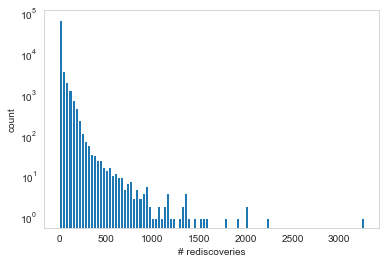

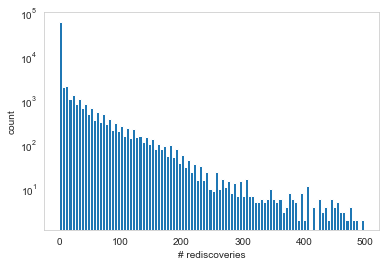

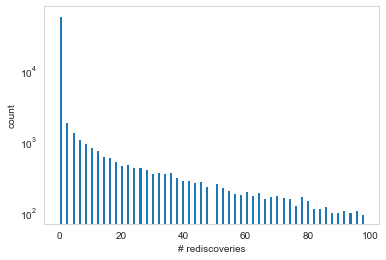

Num e=0 59035
% e=0 0.7342661691542288


(array([1508.,  421.,  354.,  343.,  301.,  167.,    8.,    0.,    0.,
          17.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

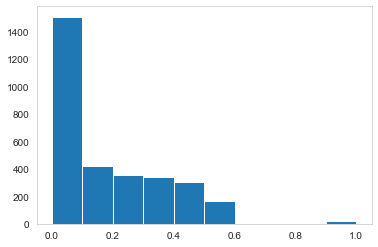

In [50]:
for k in expecteds.keys():
    print(k,len(expecteds[k]))

plt.hist(expecteds['walktrap-paris'],bins=100)
plt.yscale('log')
plt.xlabel('# rediscoveries')
plt.ylabel('count')
plt.show()
    
plt.hist([x for x in expecteds['walktrap-paris'] if x < 500],bins=100)
plt.yscale('log')
plt.xlabel('# rediscoveries')
plt.ylabel('count')
plt.show()

plt.hist([x for x in expecteds['walktrap-paris'] if x < 100],bins=100)
plt.yscale('log')
plt.xlabel('# rediscoveries')
plt.ylabel('count')
plt.show()

num_zeros = sum([ x == 0 for x in expecteds['walktrap-paris']])
print('Num e=0',num_zeros)
print('% e=0',num_zeros/len(expecteds['walktrap-paris']))


plt.hist(l2r_p_df['p-value'])

greedy-paris
(441, 6)
greedy-paris log-2-ratio 0.67% > 0, 0.06% = 0 and 0.27% < 0
exceed expecteations and perfect significance (19, 7)
(264, 7)


/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_54335/3476107025.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['l2r'] = [ is_valid(x) for x in sub['log2ratio']]


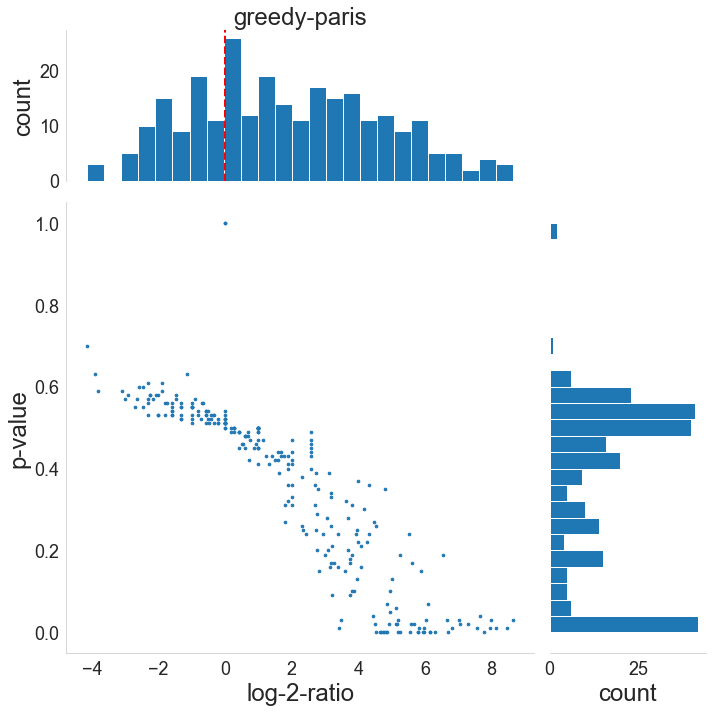

walktrap-paris
(103, 6)
walktrap-paris log-2-ratio 0.76% > 0, 0.04% = 0 and 0.2% < 0
exceed expecteations and perfect significance (12, 7)
(55, 7)


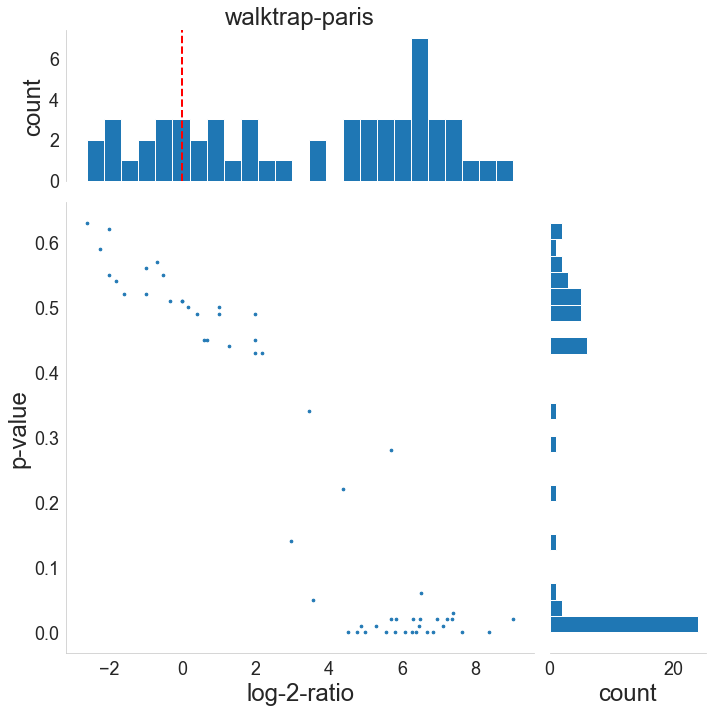

infomap-paris
(285, 6)
infomap-paris log-2-ratio 0.76% > 0, 0.06% = 0 and 0.18% < 0
exceed expecteations and perfect significance (26, 7)
(150, 7)


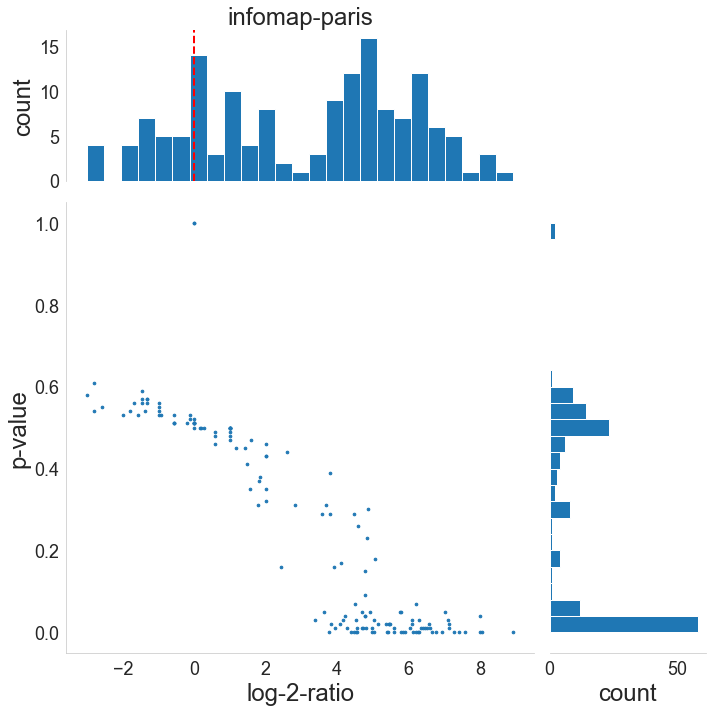

cesna-paris
(2290, 6)
cesna-paris log-2-ratio 0.94% > 0, 0.04% = 0 and 0.01% < 0
exceed expecteations and perfect significance (204, 7)
(423, 7)


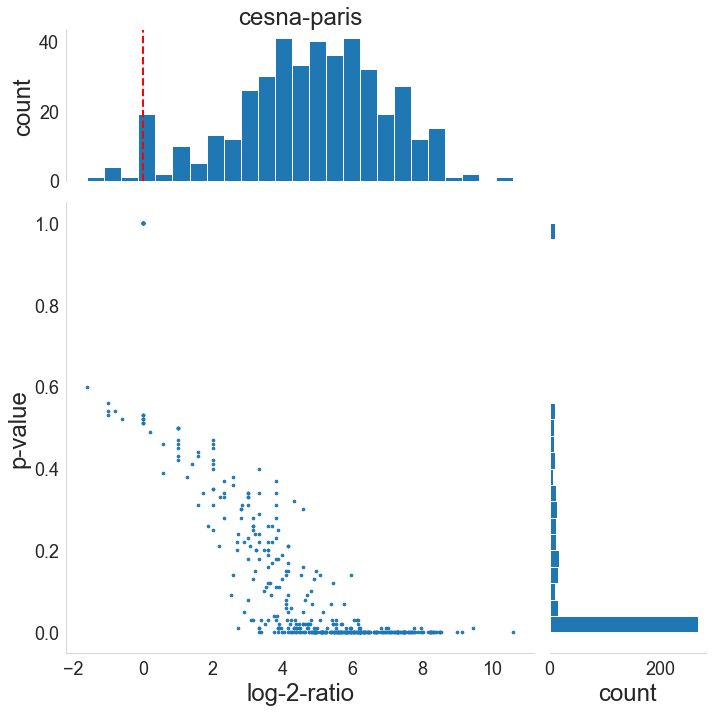

super sig counts [19, 12, 26, 204]
super sig percent [0.07196969696969698, 0.21818181818181817, 0.17333333333333334, 0.48226950354609927]
261


In [58]:
def is_valid(x):
    if math.isinf(x):
#         print('Inf')
        return 'ignore'
    elif x == 0 or math.isnan(x):
#         print('Zero')
        return 0
    else:
#         if math.isnan(np.log2(x)):
#             print(x)
        return x

# l2r_p_df['log2_ratio'] = [ control_inf(x) for x in l2r_p_df['log2ratio']]
# plt.scatter(l2r_p_df['log2ratio'], l2r_p_df['p-value'],s=1)
# plt.show()

super_sig_counts = []
super_sig_percents = []
for algo in algos:
    print(algo)
    sub = l2r_p_df[l2r_p_df['algorithm'] == algo]
    print(sub.shape)
    sub['l2r'] = [ is_valid(x) for x in sub['log2ratio']]
    sub = sub[sub['l2r'] != 'ignore']
    l2r_gr8_0 = round(sum(sub['l2r'] > 0) / sub.shape[0],2)
    l2r_eq_0 = round(sum(sub['l2r'] == 0) / sub.shape[0],2)
    l2r_sub_0 = round(sum(sub['l2r'] < 0) / sub.shape[0],2)
    print('{} log-2-ratio {}% > 0, {}% = 0 and {}% < 0'.format(algo,str(l2r_gr8_0),str(l2r_eq_0),str(l2r_sub_0)))
    subsub = sub[sub['p-value'] <= 0.0001]
    subsub = subsub[subsub['l2r'] > 0]
    print('exceed expecteations and perfect significance',subsub.shape)
    super_sig_counts.append(subsub.shape[0])
    super_sig_percents.append(subsub.shape[0]/sub.shape[0])
    print(sub.shape)
    fig, axes = plt.subplots(2,2, gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [1, 3]})
    fig.set_size_inches(10, 10)
    axes[1,0].scatter(sub['l2r'], sub['p-value'],s=7)
    axes[0,0].hist(sub['l2r'],bins=25)
    axes[1,1].hist(sub['p-value'],bins=25,orientation='horizontal')
    axes[0,1].set_visible(False)
#     axes[0,0].set_yscale('log')
#     axes[1,1].set_xscale('log')
    
    clear_ax(axes[0,0],bottom=False,left=True)
    clear_ax(axes[1,0],bottom=True,left=True)
    clear_ax(axes[0,1],bottom=False,left=False)
    clear_ax(axes[1,1],bottom=True,left=False)
    
    axes[0,0].tick_params(axis='x', labelsize=std_fontsize*1.5)
    axes[0,0].tick_params(axis='y', labelsize=std_fontsize*1.5)
    axes[1,0].tick_params(axis='x', labelsize=std_fontsize*1.5)
    axes[1,0].tick_params(axis='y', labelsize=std_fontsize*1.5)
    axes[1,1].tick_params(axis='x', labelsize=std_fontsize*1.5)
    axes[1,1].tick_params(axis='y', labelsize=std_fontsize*1.5)
    
    axes[0,0].set_title(algo, fontsize=std_fontsize*2)
    axes[0,0].set_ylabel('count', fontsize=std_fontsize*2)
    axes[1,0].set_ylabel('p-value', fontsize=std_fontsize*2)
    axes[1,0].set_xlabel('log-2-ratio', fontsize=std_fontsize*2)
    axes[1,1].set_xlabel('count', fontsize=std_fontsize*2)
    axes[0,0].axvline(x=0, linewidth=2, color='r', ls='--')
    axes[1,1].set_yticklabels([])
    axes[0,0].set_xticklabels([])
    
    plt.tight_layout()
    plt.savefig('../PublicationFigures/pval_l2r_scatter.{}.png'.format(algo),dpi=300)
    plt.show() 
print('super sig counts',super_sig_counts)
print('super sig percent',super_sig_percents)
print(sum(super_sig_counts))

In [59]:
# Merge the 4 3-panel plots into one plot to rule them all!
fig_files = ['../PublicationFigures/pval_l2r_scatter.{}.png'.format(x) for x in algos]
print(fig_files)
images = [Image.open(x) for x in fig_files]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (int(total_width/2), int(max_height*2)))
letters = ['A','B','C','D']
for i,im in enumerate(images):
    w = int(i/2) * max_height
    h = int(i%2) * widths[0]
#     im=Image.open(elem)
    new_im.paste(im, (h,w))
    I1 = ImageDraw.Draw(new_im)
    myFont = ImageFont.truetype('../arial.ttf', 80)
    off_set = 32
    I1.text((h+off_set, w+off_set), letters[i], font=myFont, fill=(0, 0, 0))

new_im.save('../PublicationFigures/pval_l2r_scatter.all.png')

['../PublicationFigures/pval_l2r_scatter.greedy-paris.png', '../PublicationFigures/pval_l2r_scatter.walktrap-paris.png', '../PublicationFigures/pval_l2r_scatter.infomap-paris.png', '../PublicationFigures/pval_l2r_scatter.cesna-paris.png']


## Edge Uniqueness

In [22]:
# get a list of rediscoveries per algo
def rediscover(edges,coms):
    """
    @param edges: list of edges [[node1,node2],[node1,node3],..]
    @param coms: list of BOCC objects
    """
    rediscoveries = list()
    for com in coms:
        for edge in edges:
            edge = list(edge)
            if edge[0] in com.members and edge[1] in com.members:
                edge.sort()
                rediscoveries.append(str(edge))
#                 print(com.name,edge)
    return rediscoveries

def rediscover_with_com_id(edges,coms):
    """
    @param edges: list of edges [[node1,node2],[node1,node3],..]
    @param coms: list of BOCC objects
    """
    rediscoveries = list()
    for com in coms:
        for edge in edges:
            edge = list(edge)
            if edge[0] in com.members and edge[1] in com.members:
                edge.sort()
                rediscoveries.append([com.name,edge])
                print(com.name,edge)
    return rediscoveries

g2p_edges_2022 = [e for e in G22.edges if sum('HP:' in x for x in e) == 1 and e not in G21.edges]
print(len(g2p_edges_2022))
clusters_dict_2021 = {}
for f in os.listdir('../SubComs/2021/'):
    if 'paris' not in f:
        continue
    tmp_coms = load_clusters('../SubComs/2021/' + f)
    tmp_name = f.replace('.coms.txt','').replace('paris.','').replace('.2021','')
    tmp_name += '-paris'
    rediscover(g2p_edges_2022,tmp_coms)
    clusters_dict_2021[tmp_name] = rediscover(g2p_edges_2022,tmp_coms)
    print(tmp_name)
    print(len(clusters_dict_2021[tmp_name]))

17421
walktrap-paris
364
infomap-paris
222
greedy-paris
226
cesna-paris
540


In [23]:
# calc data for uniqueness
uniq_rediscovery = {'algo':[],'infotype':[],'count':[]}
print(clusters_dict_2021.keys())
for key in clusters_dict_2021.keys():
    all_rediscoveries = list()
    for key2 in clusters_dict_2021.keys():
        if key == key2:
            continue
        # a list of all rediscoveries made by the other 3 algorithms
        all_rediscoveries = all_rediscoveries + clusters_dict_2021[key2]
    all_rediscoveries_set = set(all_rediscoveries)    
    uniq_rediscovery['algo'].append(key)
    uniq_rediscovery['infotype'].append('common')
    uniq_rediscovery['count'].append(len([x for x in set(clusters_dict_2021[key]) if x in all_rediscoveries_set]))
    common = uniq_rediscovery['count'][-1]
    
    uniq_rediscovery['algo'].append(key)
    uniq_rediscovery['infotype'].append('unique')
    uniq_rediscovery['count'].append(len([x for x in set(clusters_dict_2021[key]) if x not in all_rediscoveries_set]))
    uniq = uniq_rediscovery['count'][-1]
#     assert(common + uniq == uniq_self)

uniq_rediscovery_df = pd.DataFrame(uniq_rediscovery)
print(uniq_rediscovery_df.shape)
# assert(uniq_rediscovery_df.shape[0] == 4 * 4)

dict_keys(['walktrap-paris', 'infomap-paris', 'greedy-paris', 'cesna-paris'])
(8, 3)


1.0
greedy-paris 226.0
0.7406340057636888
walktrap-paris 347.0
0.27927927927927926
infomap-paris 222.0
0.10714285714285714
cesna-paris 504.0


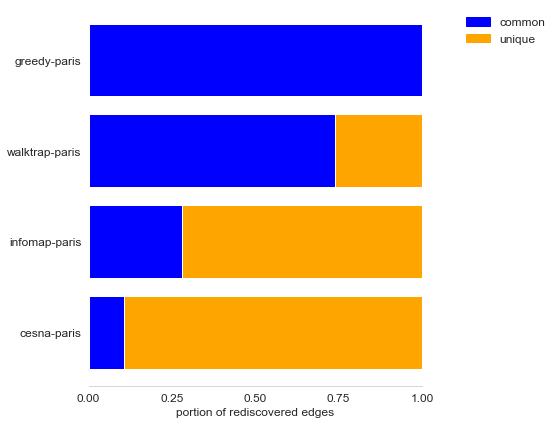

In [24]:
# bar charts of uniqueness

fig, axes = plt.subplots()
fig.set_size_inches(8, 6)
tick_names = []
spaces = '    '

for i,algo in enumerate(algos):
    tick_names.append(algo)
    sub = uniq_rediscovery_df[uniq_rediscovery_df['algo'] == algo]
    common_count = sub[sub['infotype'] == 'common']['count']
    unique_count = sub[sub['infotype'] != 'common']['count']
    common_percent = float(common_count) / (float(common_count) + float(unique_count))
    print(common_percent)
    print(algo, float(common_count) + float(unique_count))
    b1 = axes.barh(-i, common_percent, color="blue")
    b2 = axes.barh(-i, 1 - common_percent, left=common_percent, color="orange")
#     plt.text( common_percent / 2, i, 'common {}%'.format(round(common_percent,2)),fontsize=std_fontsize)
clear_ax(axes,bottom=True)
plt.yticks([-1*x for x in range(4)], tick_names, fontsize=std_fontsize)
plt.xticks([0.00,.25,.5,.75,1.00], fontsize=std_fontsize)
plt.xlabel('portion of rediscovered edges', fontsize=std_fontsize)
common_patch = mpatches.Patch(color='blue', label='common')
unique_patch = mpatches.Patch(color='orange', label='unique')
plt.legend(handles=[common_patch, unique_patch], bbox_to_anchor=(1.1, 1), frameon=False, fontsize=std_fontsize)
plt.tight_layout()
plt.savefig('../PublicationFigures/rediscovery_comon_uniq_bars.png',dpi=300)
plt.show() 

In [25]:
# print(len(global_all_rediscoveries))
# print(len(global_all_rediscoveries_set))
print(uniq_rediscovery_df)
print('common', uniq_rediscovery_df[uniq_rediscovery_df['infotype'] == 'common']['count'].sum())
print('unique', uniq_rediscovery_df[uniq_rediscovery_df['infotype'] == 'unique']['count'].sum())
print('total',uniq_rediscovery_df['count'].sum())

             algo infotype  count
0  walktrap-paris   common    257
1  walktrap-paris   unique     90
2   infomap-paris   common     62
3   infomap-paris   unique    160
4    greedy-paris   common    226
5    greedy-paris   unique      0
6     cesna-paris   common     54
7     cesna-paris   unique    450
common 599
unique 700
total 1299


## Up Set Plots
https://upsetplot.readthedocs.io/en/stable/

cesna-paris,greedy-paris,infomap-paris,walktrap-paris 3
,greedy-paris,infomap-paris,walktrap-paris 33
,cesna-paris,infomap-paris,walktrap-paris 5
,,infomap-paris,walktrap-paris 49
,cesna-paris,greedy-paris,walktrap-paris 24
,,greedy-paris,walktrap-paris 226
,,cesna-paris,walktrap-paris 41
,,,walktrap-paris 347
,cesna-paris,greedy-paris,infomap-paris 3
,,greedy-paris,infomap-paris 33
,,cesna-paris,infomap-paris 18
,,,infomap-paris 222
,,cesna-paris,greedy-paris 24
,,,greedy-paris 226
,,,cesna-paris 504


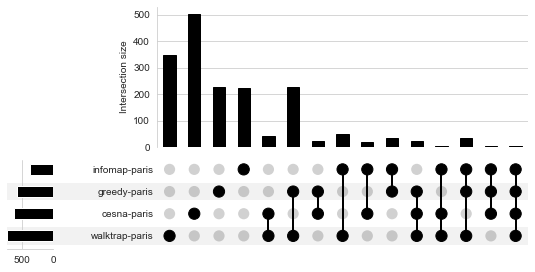

In [26]:
# print(clusters_dict_2021.keys())
# print(clusters_dict_2021[tmp_name])

def remove_items(test_list, item):
 
    # using list comprehension to perform the task
    res = [i for i in test_list if i != item]
 
    return res

plt_categories = []
plt_counts = []
upset_plot_results = {}
keys = list(clusters_dict_2021.keys()) + ['']
for key1 in list(clusters_dict_2021.keys()):
    set1 = set(clusters_dict_2021[key1])
    for key2 in keys:
        if key2 != '':
            set2 = set(clusters_dict_2021[key2])
            s12 = set2.intersection(set1)
        else:
            s12 = set1
        for key3 in keys:
            if key3 != '':
                set3 = set(clusters_dict_2021[key3])
                s123 = s12.intersection(set3)
            else:
                s123 = s12
            for key4 in keys:
                if key4 != '':
                    set4 = set(clusters_dict_2021[key4])
                    s1234 = s123.intersection(set4)
                else:
                    s1234 = s123
                these_keys = [key1,key2,key3,key4]
                these_keys2 = these_keys
                if '' in these_keys2:
                    these_keys2 = remove_items(these_keys2, '')
                if len(these_keys2) != len(set(these_keys2)):
                    continue
                these_keys.sort()
                if ','.join(these_keys) in upset_plot_results:
                    continue
                upset_plot_results[','.join(these_keys)] = len(s1234)
                plt_categories.append(these_keys2)
                plt_counts.append(len(s1234))
                    
for k in upset_plot_results.keys():
    print(k, upset_plot_results[k])

example = from_memberships(plt_categories,data=plt_counts)
plot(example)
plt.savefig('../PublicationFigures/upsetplot.png',dpi=300)

## Drug discovery g2p downsampling

In [32]:
# function to read in edge list 
def read_edgelist(filename):
    edges = []
    with open(filename) as infile:
        for line in infile:
            edge = line.strip().split('\t')
            edges.append(edge)
    return edges

# function to count the number of times each gene is in the list
def count_genes(edges):
    gene_counts = {}
    for edge in edges:
        gene = edge[1]
        if gene not in gene_counts:
            gene_counts[gene] = 0
        gene_counts[gene] += 1
    return gene_counts

# function to plot a histogram of the gene counts
def get_gene_counts_hist_bins(gene_counts):
    bs = plt.hist(gene_counts.values(),bins=100)
    plt.clf()
    return bs

# function to sample a gene_count dict to match the bins returned from plot_gene_counts
def sample_to_match_bins(gene_counts,bs):
    # set the random seed
    np.random.seed(0)
    # get the bin edges
    bin_edges = bs[1]
    # get the bin counts
    bin_counts = bs[0]
    # get the bin centers

    # sample the gene counts to match the bin counts
    sampled_gene_counts = {}
    for i in range(len(bin_edges)-1):
        # get the number of genes in the bin
        num_genes = bin_counts[i]
        # get the number of phenotypes in the bin
        num_phenotypes = bin_counts[i]
        # get the genes in the bin
        genes_in_bin = [g for g in gene_counts.keys() if gene_counts[g] >= bin_edges[i] and gene_counts[g] < bin_edges[i+1]]
        print(len(genes_in_bin))
        # sample the genes in the bin to match the bin count
        # print(genes_in_bin)
        # print(num_genes)
        sampled_genes = np.random.choice(genes_in_bin,size=int(num_genes),replace=False)
        # add the sampled genes to the sampled_gene_counts dict
        for g in sampled_genes:
            sampled_gene_counts[g] = gene_counts[g]
    return sampled_gene_counts

# function to remove top and right border form an axis
def remove_top_right_border(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# function to plot 3 histograms of the gene counts, each in their own axis
def plot_3_gene_counts(gene_counts1,gene_counts2,gene_counts3,figname):
    # get the number of phenotypes in each gene_counts dict
    num_phenotypes1 = sum(gene_counts1.values())
    num_phenotypes2 = sum(gene_counts2.values())
    num_phenotypes3 = sum(gene_counts3.values())
    # plot the histograms
    fig, axs = plt.subplots(1,3)
    fig.set_size_inches(18, 6)
    axs[0].hist(gene_counts1.values(),bins=100)
    axs[0].set_xlabel('number of phenotypes per gene',fontsize=std_fontsize)
    axs[0].set_ylabel('count',fontsize=std_fontsize)
    axs[0].set_title('A                             # edges={}'.format(str(num_phenotypes1)),loc='left',fontsize=std_fontsize)
    axs[1].hist(gene_counts2.values(),bins=100)
    axs[1].set_xlabel('number of phenotypes per gene',fontsize=std_fontsize)
    axs[1].set_ylabel('count',fontsize=std_fontsize)
    axs[1].set_title('B                             # edges={}'.format(str(num_phenotypes2)),loc='left',fontsize=std_fontsize)
    axs[2].hist(gene_counts3.values(),bins=100)
    axs[2].set_xlabel('number of phenotypes per gene',fontsize=std_fontsize)
    axs[2].set_ylabel('count',fontsize=std_fontsize)
    axs[2].set_title('C                             # edges={}'.format(str(num_phenotypes3)),loc='left',fontsize=std_fontsize)
    remove_top_right_border(axs[0])
    remove_top_right_border(axs[1])
    remove_top_right_border(axs[2])
    plt.savefig(figname)
    plt.show()

# function to selecte the edges related to genes from the gene_counts dict and write them to a file
def select_edges(edges,gene_counts,outfile):
    # get the genes from the gene_counts dict
    genes = gene_counts.keys()
    # open the output file
    with open(outfile,'w') as out:
        # loop over the edges
        for edge in edges:
            # get the gene
            gene = edge[1]
            # check if the gene is in the gene_counts dict
            if gene in genes:
                # write the edge to the output file
                out.write('\t'.join(edge)+'\n')

In [33]:
#g2p_Edgelists/String_HPO_2022.phenotypic_branch.g2p_edgelist.txt Resources/new_drug_edges.txt Figures/drug_inferred_p_per_g.png
edges1 = read_edgelist('../g2p_Edgelists/String_HPO_2022.phenotypic_branch.g2p_edgelist.txt')
edges2 = read_edgelist('../Resources/new_drug_edges.txt')
# count the number of times each gene is in the list
gene_counts1 = count_genes(edges1)
gene_counts2 = count_genes(edges2)
# plot a histogram of the gene counts
bs1 = get_gene_counts_hist_bins(gene_counts1)
bs2 = get_gene_counts_hist_bins(gene_counts2)
# sample the gene counts to match the bins returned from plot_gene_counts
sampled_gene_counts = sample_to_match_bins(gene_counts2,bs1)
# plot 3 histograms of the gene counts, each in their own axis
# plot_3_gene_counts(gene_counts2,gene_counts1,sampled_gene_counts,'../Figures/drug_inferred_p_per_g.png')
select_edges(edges2,sampled_gene_counts,'../Resources/new_drug_edges_sampled.txt')

9660
3147
3234
1164
960
1005
754
825
708
570
593
524
493
375
291
477
452
538
405
312
330
277
268
281
220
320
236
285
311
238
273
247
229
277
382
326
303
338
414
316
354
377
354
391
362
323
430
377
438
370
389
487
378
451
413
362
439
359
433
373
328
344
319
288
371
297
294
252
232
244
198
218
177
156
163
136
140
87
91
105
78
77
82
77
66
48
54
53
36
43
30
29
35
30
25
27
17
26
14
22


<Figure size 432x288 with 0 Axes>

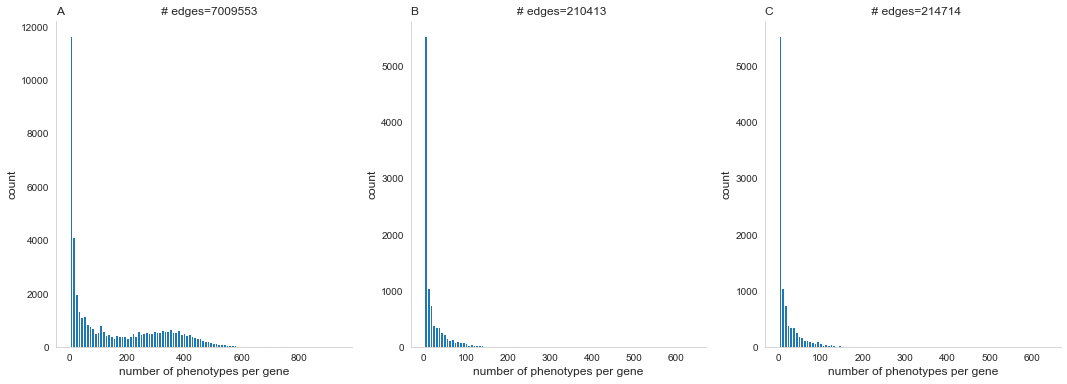

In [34]:
plot_3_gene_counts(gene_counts2,gene_counts1,sampled_gene_counts,'../PublicationFigures/drug_inferred_p_per_g.png')

## Rediscoveries year after year

In [5]:
# load 2019 coms
g_subcoms_19 = load_clusters('../SubComs/2019/paris.greedy.2019.coms.txt')
w_subcoms_19 = load_clusters('../SubComs/2019/paris.walktrap.2019.coms.txt')
i_subcoms_19 = load_clusters('../SubComs/2019/paris.infomap.2019.coms.txt')
c_subcoms_19 = load_clusters('../SubComs/2019/paris.cesna.2019.coms.txt')

In [7]:
def get_possible_pairs_from_com(coms,_G):
    # this function returns a list of all possible pairings of genes and phenotypes in all clusters - regardless of if they exist or not
    pairs = set()
    for com in coms:
        genes = [x for x in com.members if 'HP:' not in x]
        hpos = [x for x in com.members if 'HP:' in x]
#         print('HPOs',len(hpos))
#         print('Genes',len(genes))
        for g in genes:
            for h in hpos:
                if _G.has_edge(g,h):
                    continue
                p=[g,h]
                p.sort()
                pairs.add(str(p))
    return pairs

g_subcoms_19_pairs = get_possible_pairs_from_com(g_subcoms_19,G19)
w_subcoms_19_pairs = get_possible_pairs_from_com(w_subcoms_19,G19)
i_subcoms_19_pairs = get_possible_pairs_from_com(i_subcoms_19,G19)
c_subcoms_19_pairs = get_possible_pairs_from_com(c_subcoms_19,G19)
print(len(g_subcoms_19))
print(len(g_subcoms_19_pairs))
print(len(w_subcoms_19_pairs))
print(len(i_subcoms_19_pairs))
print(len(c_subcoms_19_pairs))

1479
47812
43030
37899
15093


In [17]:
def load_new_edges(el):
    pairs = set()
    for line in open(el,'r'):
        row = line.strip().split('\t')
        row.sort()
        pairs.add(str(row))
    return pairs

new_19_pairs = load_new_edges('../g2p_Edgelists/String_HPO_2019.phenotypic_branch.g2p_edgelist.txt')
new_20_pairs = load_new_edges('../g2p_Edgelists/String_HPO_2020.phenotypic_branch.g2p_edgelist.txt')
new_21_pairs = load_new_edges('../g2p_Edgelists/String_HPO_2021.phenotypic_branch.g2p_edgelist.txt')
new_22_pairs = load_new_edges('../g2p_Edgelists/String_HPO_2022.phenotypic_branch.g2p_edgelist.txt')
print(len(new_20_pairs))
print(len(new_21_pairs))
print(len(new_22_pairs))

# remove edges that are in 19 already
new_20_pairs = set([x for x in new_20_pairs if x not in new_19_pairs])
new_21_pairs = set([x for x in new_21_pairs if x not in new_19_pairs])
new_22_pairs = set([x for x in new_22_pairs if x not in new_19_pairs])

print(len(new_20_pairs))
print(len(new_21_pairs))
print(len(new_22_pairs))

new_21_vs_20_pairs = [x for x in new_21_pairs if x not in new_20_pairs]
print('Number of possible new edges 2021 v 2022', len(new_21_vs_20_pairs))


170892
197926
210413
130314
158358
171489
Number of possible new edges 2021 v 2022 31838


In [19]:
def rediscover(pairs, el_pairs):
    # find the intersection
    return pairs.intersection(el_pairs)

g_re_19_on_20 = rediscover(g_subcoms_19_pairs, new_20_pairs)
g_re_19_on_21 = rediscover(g_subcoms_19_pairs, new_21_pairs)
g_re_19_on_22 = rediscover(g_subcoms_19_pairs, new_22_pairs)

w_re_19_on_20 = rediscover(w_subcoms_19_pairs, new_20_pairs)
w_re_19_on_21 = rediscover(w_subcoms_19_pairs, new_21_pairs)
w_re_19_on_22 = rediscover(w_subcoms_19_pairs, new_22_pairs)

i_re_19_on_20 = rediscover(i_subcoms_19_pairs, new_20_pairs)
i_re_19_on_21 = rediscover(i_subcoms_19_pairs, new_21_pairs)
i_re_19_on_22 = rediscover(i_subcoms_19_pairs, new_22_pairs)

c_re_19_on_20 = rediscover(c_subcoms_19_pairs, new_20_pairs)
c_re_19_on_21 = rediscover(c_subcoms_19_pairs, new_21_pairs)
c_re_19_on_22 = rediscover(c_subcoms_19_pairs, new_22_pairs)


print('total possible number of rediscoveries', len(w_subcoms_19_pairs) + len(g_subcoms_19_pairs) +len(i_subcoms_19_pairs) +len(c_subcoms_19_pairs))

print('\n\n\n')
print('Total number of rediscoveries')
print('greedy 20', len(g_re_19_on_20))
print('greedy 21', len(g_re_19_on_21))
print('greedy 22', len(g_re_19_on_22))
print('walktrap 20',len(w_re_19_on_20))
print('walktrap 21',len(w_re_19_on_21))
print('walktrap 22',len(w_re_19_on_22))
print('infomap 20',len(i_re_19_on_20))
print('infomap 21',len(i_re_19_on_21))
print('infomap 22',len(i_re_19_on_22))
print('cesna 20',len(c_re_19_on_20))
print('cesna 21',len(c_re_19_on_21))
print('cesna 22',len(c_re_19_on_22))
print()
print('total 20',len(c_re_19_on_20) + len(g_re_19_on_20) + len(w_re_19_on_20) + len(i_re_19_on_20))
print('total 21',len(c_re_19_on_21) + len(g_re_19_on_21) + len(w_re_19_on_21) + len(i_re_19_on_21))
print('total 22',len(c_re_19_on_22) + len(g_re_19_on_22) + len(w_re_19_on_22) + len(i_re_19_on_22))
unique_19_21 = c_re_19_on_21.union(g_re_19_on_21).union(i_re_19_on_21).union(w_re_19_on_21)
unique_19_22 = c_re_19_on_22.union(g_re_19_on_22).union(i_re_19_on_22).union(w_re_19_on_22)
print(len(unique_19_21))
print(len(unique_19_22))
print('total unique rediscoveries in 19v21 and 19v22',len(unique_19_22.union(unique_19_21)))

print('\n\n\n')
print('% edge new edges that were rediscovered')
print('greedy 20', round(len(g_re_19_on_20) / len(new_20_pairs),3))
print('greedy 21', round(len(g_re_19_on_21) / len(new_21_pairs),3))
print('greedy 22', round(len(g_re_19_on_22) / len(new_22_pairs),3))
print('walktrap 20',round(len(w_re_19_on_20) / len(new_20_pairs),3))
print('walktrap 21',round(len(w_re_19_on_21) / len(new_21_pairs),3))
print('walktrap 22',round(len(w_re_19_on_22) / len(new_22_pairs),3))
print('infomap 20',round(len(i_re_19_on_20) / len(new_20_pairs),3))
print('infomap 21',round(len(i_re_19_on_21) / len(new_21_pairs),3))
print('infomap 22',round(len(i_re_19_on_22) / len(new_22_pairs),3))
print('cesna 20',round(len(c_re_19_on_20) / len(new_20_pairs),3))
print('cesna 21',round(len(c_re_19_on_21) / len(new_21_pairs),3))
print('cesna 22',round(len(c_re_19_on_22) / len(new_22_pairs),3))

print('\n\n\n')
print('Average number of rediscoveries per cluster')
print('greedy 20', round(len(g_re_19_on_20) / len(g_subcoms_19),3))
print('greedy 21', round(len(g_re_19_on_21) / len(g_subcoms_19),3))
print('greedy 22', round(len(g_re_19_on_22) / len(g_subcoms_19),3))
print('walktrap 20',round(len(w_re_19_on_20) / len(g_subcoms_19),3))
print('walktrap 21',round(len(w_re_19_on_21) / len(g_subcoms_19),3))
print('walktrap 22',round(len(w_re_19_on_22) / len(g_subcoms_19),3))
print('infomap 20',round(len(i_re_19_on_20) / len(g_subcoms_19),3))
print('infomap 21',round(len(i_re_19_on_21) / len(g_subcoms_19),3))
print('infomap 22',round(len(i_re_19_on_22) / len(g_subcoms_19),3))
print('cesna 20',round(len(c_re_19_on_20) / len(g_subcoms_19),3))
print('cesna 21',round(len(c_re_19_on_21) / len(g_subcoms_19),3))
print('cesna 22',round(len(c_re_19_on_22) / len(g_subcoms_19),3))

total possible number of rediscoveries 143834




Total number of rediscoveries
greedy 20 241
greedy 21 306
greedy 22 327
walktrap 20 236
walktrap 21 321
walktrap 22 347
infomap 20 222
infomap 21 297
infomap 22 318
cesna 20 263
cesna 21 443
cesna 22 495

total 20 962
total 21 1367
total 22 1487
1011
1107
total unique rediscoveries in 19v21 and 19v22 1125




% edge new edges that were rediscovered
greedy 20 0.002
greedy 21 0.002
greedy 22 0.002
walktrap 20 0.002
walktrap 21 0.002
walktrap 22 0.002
infomap 20 0.002
infomap 21 0.002
infomap 22 0.002
cesna 20 0.002
cesna 21 0.003
cesna 22 0.003




Average number of rediscoveries per cluster
greedy 20 0.163
greedy 21 0.207
greedy 22 0.221
walktrap 20 0.16
walktrap 21 0.217
walktrap 22 0.235
infomap 20 0.15
infomap 21 0.201
infomap 22 0.215
cesna 20 0.178
cesna 21 0.3
cesna 22 0.335
